In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# 1. Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Необходимо исследовать данные и выяснить:
1. Какие факторы влияют на зарплату специалиста *Data Science*.
2. Получить ответы на следующие вопросы:
  - Наблюдается ли ежегодный рост зарплат у специалистов *Data Scientist*?
  - Как соотносятся зарплаты *Data Scientist* и *Data Engineer* в 2022 году?
  - Как соотносятся зарплаты специалистов *Data Scientist* в компаниях различных размеров?
  - Есть ли связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha = 0.05$.

# 2. Загрузка данных

Для ответа на вопросы имеем данные о профессиях *Data Science* и *Data Engineer* за 2020-2022 года.

Данные содержат следуующие столбцы:
- `work_year` - год, в котором была выплачена зарплата;
- `experience_level` - опыт работы на этой должности в течение года со следующими возможными значениями:
  - EN — Entry-level/Junior;
  - MI — Mid-level/Intermediate;
  - SE — Senior-level/Expert;
  - EX — Executive-level/Director.
- `employment_type` - Тип трудоустройства для этой роли:
  - PT — неполный рабочий день;
  - FT — полный рабочий день;
  - CT — контракт;
  - FL — фриланс.
- `job_title` - роль, в которой соискатель работал в течение года;
- `salary` - общая выплаченная валовая сумма заработной платы;
- `salary_currency` - валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
- `salary_in_usd` - зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через *fxdata.foorilla.com*);
- `employee_residence` - основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
- `remote_ratio` - общий объём работы, выполняемой удалённо. Возможные значения:
  - 0 — удалённой работы нет (менее 20 %);
  - 50 — частично удалённая работа;
  - 100 — полностью удалённая работа (более 80 %).
- `company_location` - страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
- `company_size` - среднее количество людей, работавших в компании в течение года:
  - *S* — менее 50 сотрудников (небольшая компания);
  - *M* — от 50 до 250 сотрудников (средняя компания);
  - *L* — более 250 сотрудников (крупная компания).

In [2]:
# загрузка данных

data = pd.read_csv('ds_salaries.csv')

display(data.head())

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


# 3. Описательный анализ данных

Проведем описательный анализ данных.

In [3]:
# вывод информацию о датасете:

display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


None

В датасете 607 записей, без пропущенных значений, типы данных в столбцах вполне корректны.

Проверим датасет на наличие дубликатов и избавимся от них, если они присутствуют.

In [4]:
# проверка датасета на наличие дубликатов

display(f'Размер таблицы до удаления дубликатов: {data.shape}')

count_duples = data[data.duplicated()].shape[0]
display(f'Количество дубликатов: {count_duples}')

data = data.drop_duplicates()
display(f'Размер таблицы после удаления дубликатов: {data.shape}')

'Размер таблицы до удаления дубликатов: (607, 12)'

'Количество дубликатов: 0'

'Размер таблицы после удаления дубликатов: (607, 12)'

Дубликаты в датасете отсутствуют.

Далее определим неинформативные признаки:

- Признак `Unnamed: 0` дублирует нумерацию строк, он не дает никакой полезной информации;
- Признаки `salary` и `salary_in_usd` указывают размер выплаченной зарплаты. Признак `salary` указыется в разных валютах в соответствии с признаком `salary_currency`, а `salary_in_usd` указана в долларах для всех записей. Оставим признак `salary_in_usd`, так как он отражает размер выплаченной зарплаты в долларах для всех записей (не потребуется переводить все в одну валюту).

Удалим признаки `Unnamed: 0`, `salary` и `salary_currency`:

In [5]:
# удаление неинформативных признаков

data = data.drop(['Unnamed: 0', 'salary', 'salary_currency'], axis=1)

Классифицируем оставшиеся признаки:
- `salary_in_usd` - числовой признак;
- все остальные признаки, а именно:
  - `work_year`;
  - `experience_level`;
  - `employment_type`;
  - `job_title`;
  - `employee_residence`;
  - `remote_ratio`;
  - `company_location`;
  - `company_size`
  
  являются категориальными.

Найдем статистические характеристики для каждого из признаков. Так как у нас практически все признаки категориальны, найдем моду для каждого из признаков и выведем отдельно таблицу со статистическими характеристиками признака `salary_in_usd`:

In [6]:
# вывод статистических характеристик признаков датасета

display('Популярные значения признаков:', data.mode().iloc[0])
display('Статистические характеристики признака "salary_in_usd":', data['salary_in_usd'].describe().round(2).to_frame())

'Популярные значения признаков:'

work_year                       2022
experience_level                  SE
employment_type                   FT
job_title             Data Scientist
salary_in_usd                 100000
employee_residence                US
remote_ratio                     100
company_location                  US
company_size                       M
Name: 0, dtype: object

'Статистические характеристики признака "salary_in_usd":'

,salary_in_usd
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


# 4. Анализ влияния признаков

Рассмотрим оставшиеся признаки и выясним, какие из них оказывают влияние на размер заработной платы специалистов Data Scientist:

- `work_year` - год выплаты зарплаты: не оказывает влияния;
- `experience_level` - опыт работы: может оказывать существенное влияние на размер зарплаты;
- `employment_type` - тип трудоустройства: может оказывать влияние на размер зарплаты;
- `job_title` - наименование специальности: не оказывает влияния на размер зарплаты;
- `salary_in_usd` - зарплата в долларах: размер зарплаты, который будем анализировать;
- `employee_residence` - страна проживания сотрудника: может оказывать влияние на размер зарплаты;
- `remote_ratio` - объем выполняемой работы: может оказывать влияние на размер зарплаты;
- `company_location` - страна главного офиса работодателя: может оказывать влияние на размер зарплаты;
- `company_size` - размер компании: может оказывать влияние на размер зарплаты.

Проанализируем влияние следующих признаков на зарплату:
1. `experience_level`;
2. `employment_type`;
3. `remote_ratio`;
4. `company_location`;
5. `company_size`.

Проведем визуальных анализ перечисленных признаков.

Для начала подготовим датасет - отфильтруем исходные данные для специалистов Data Scientist.

In [7]:
# фильтрация данных датасета для специальности Data Scientist

ds_data = data[data['job_title'] == 'Data Scientist']

## 4.1 Опыт работы (experience_level)

Рассмотрим зарплаты специалистов Data Scientist для разных типов опыта работы. Напомним категории опыта работы:
  - EN — Entry-level/Junior;
  - MI — Mid-level/Intermediate;
  - SE — Senior-level/Expert;
  - EX — Executive-level/Director.

Для лучшей наглядности проведем замену значений признака `experience_level` на числовые значения по возрастанию опыта работы: *EN* - 1, *MI* - 2, *SE* - 3, *EX* - 4.

Построим коробчатую диаграмму.

C:\Users\User\AppData\Local\Temp\ipykernel_8144\2248743710.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_data['experience_level'] = ds_data['experience_level'].apply(lambda x: dct[x])


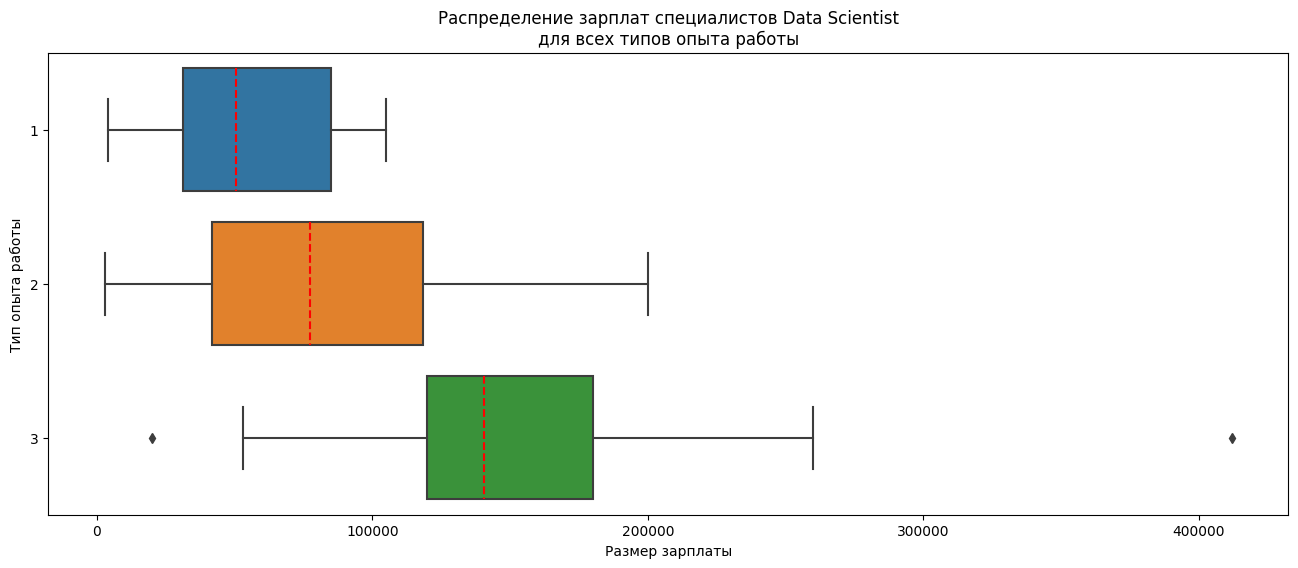

In [8]:
# построение коробчатой диаграммы распределения зарплат по опыту работы

dct = {
    'EN': 1,
    'MI': 2,
    'SE': 3,
    'EX': 4
}

ds_data['experience_level'] = ds_data['experience_level'].apply(lambda x: dct[x])

fig, ax = plt.subplots(figsize=(16, 6))

sns.boxplot(
    data=ds_data,
    x='salary_in_usd',
    y='experience_level',
    orient='h',
    medianprops={
        'color': 'red',
        'linestyle': '--'
    },
    ax=ax
)
ax.set(xlabel='Размер зарплаты', ylabel='Тип опыта работы')
ax.set_title('Распределение зарплат специалистов Data Scientist\nдля всех типов опыта работы');

Выведем основные статистические характеристики:

In [9]:
# вывод статистических характеристик

ds_agg = ds_data.groupby('experience_level')['salary_in_usd'].describe().round(2)

display(ds_agg)

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
1,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
2,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
3,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


Диаграмма показывает, что чем больше опыт работы, тем больше зарплата. Аналогичную информацию дают числовые характеристики: размер средней и медианной зарплаты увеличивается с ростом опыта работы. Можно предположить, что опыт работы влияет на зарплату специалистов Data Scientist.

## 4.2 Тип трудоустройства (employment_type)

Рассмотрим распределение зарплаты специалистов Data Scientist для разных типов трудоустройства:

- PT — неполный рабочий день;
- FT — полный рабочий день;
- CT — контракт;
- FL — фриланс.

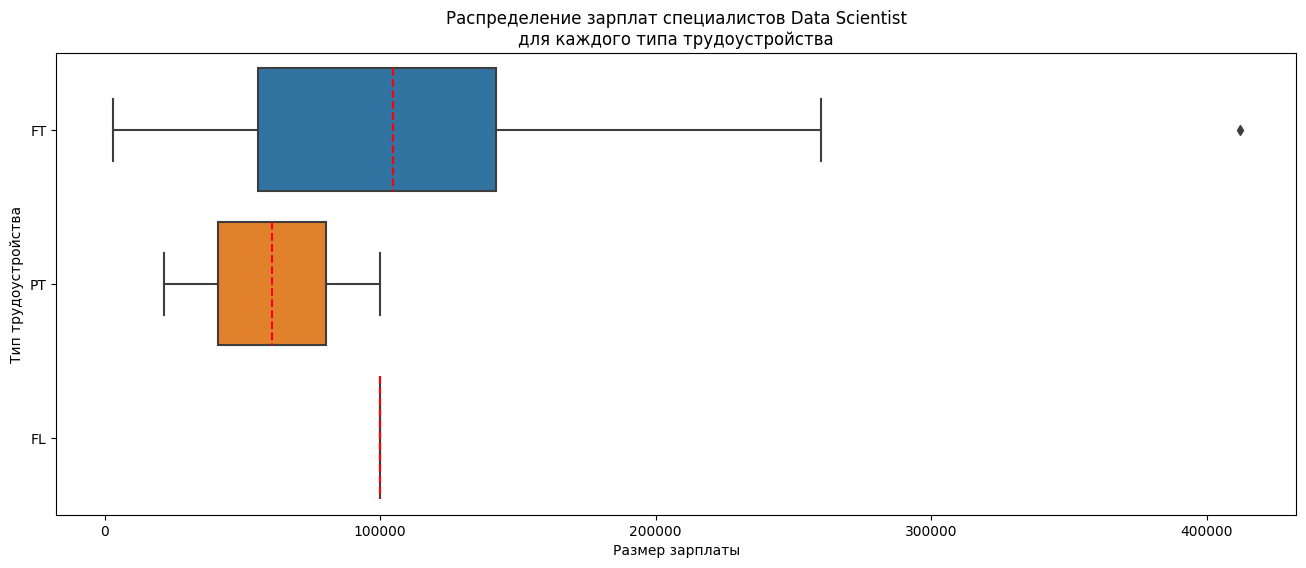

In [10]:
# построение коробчатой диаграммы распределения зарплаты по типам трудоустройства

fig, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(
    data=ds_data,
    x='salary_in_usd',
    y='employment_type',
    orient='h',
    medianprops={
        'color': 'red',
        'linestyle': '--'
    },
    ax=ax
)
ax.set(xlabel='Размер зарплаты', ylabel='Тип трудоустройства')
ax.set_title('Распределение зарплат специалистов Data Scientist\nдля каждого типа трудоустройства');

In [11]:
# вывод количества каждого типа трудоустройства

display(ds_data['employment_type'].value_counts())

FT    140
PT      2
FL      1
Name: employment_type, dtype: int64

Выведем основные статистические характеристики:

In [12]:
# вывод статистических характеристик

ds_agg = ds_data.groupby('employment_type')['salary_in_usd'].describe().round(2)

display(ds_agg)

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,140.0,108922.79,64372.43,2859.0,55490.00,104796.0,141975.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


Сложно оценить влияние типа трудостройства на зарплату специалистов Data Scientist, так как для типа "фриланс" (FL) и "неполный рабочий день" (PT) всего 1 и 2 записи соответственно.

## 4.3 Общий объем работы, выполняемой удаленно (remote_ratio)

Рассмотрим распределение зарплаты специалистов Data Scientist по объему выполняемой удаленной работы:

- 0 — удалённой работы нет (менее 20 %);
- 50 — частично удалённая работа;
- 100 — полностью удалённая работа (более 80 %).

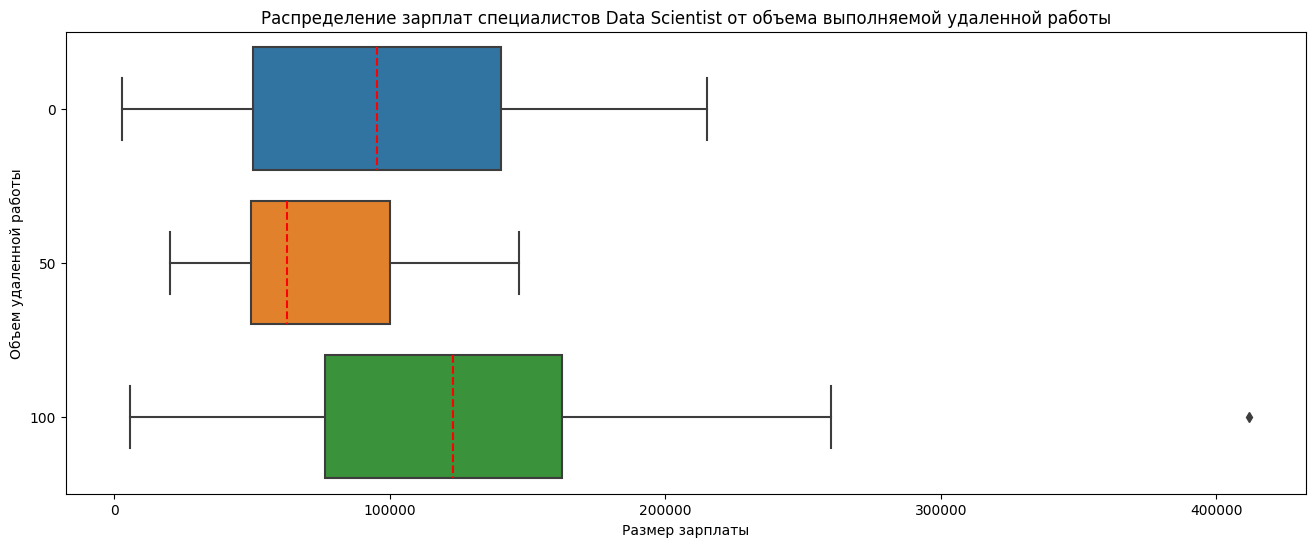

In [13]:
# построение коробчатой диаграммы распределения зарплаты по объему работы, выполняемой удаленно

fig, ax = plt.subplots(figsize=(16, 6))

sns.boxplot(
    data=ds_data,
    x='salary_in_usd',
    y='remote_ratio',
    orient='h',
    medianprops={
        'color': 'red',
        'linestyle': '--'
    },
    ax=ax
)
ax.set(xlabel='Размер зарплаты', ylabel='Объем удаленной работы')
ax.set_title('Распределение зарплат специалистов Data Scientist от объема выполняемой удаленной работы');

Выведем основные статистические характеристики:

In [14]:
# вывод статистических характеристик

ds_agg = ds_data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)

display(ds_agg)

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.74,58259.42,2859.0,50294.5,95550.0,140400.0,215300.0
50,25.0,74504.08,35602.82,20171.0,49646.0,62726.0,100000.0,147000.0
100,79.0,123125.94,69370.99,5679.0,76366.0,123000.0,162500.0,412000.0


По данным диаграммы и числовых характеристик зарплата специалистов Data Scientist, которые выполняют менее 20% удаленной работы, а также полностью выполняют удаленную работу, выше, чем у специалистов Data Scientist, у которых частично удаленная работа. Наибольшая заработная плата у специалистов, выполняющих работу удаленно.

## 4.4 Страна головного офиса (company_location)

Рассмотрим, сколько головных офисов компаний находится в каждой стране:

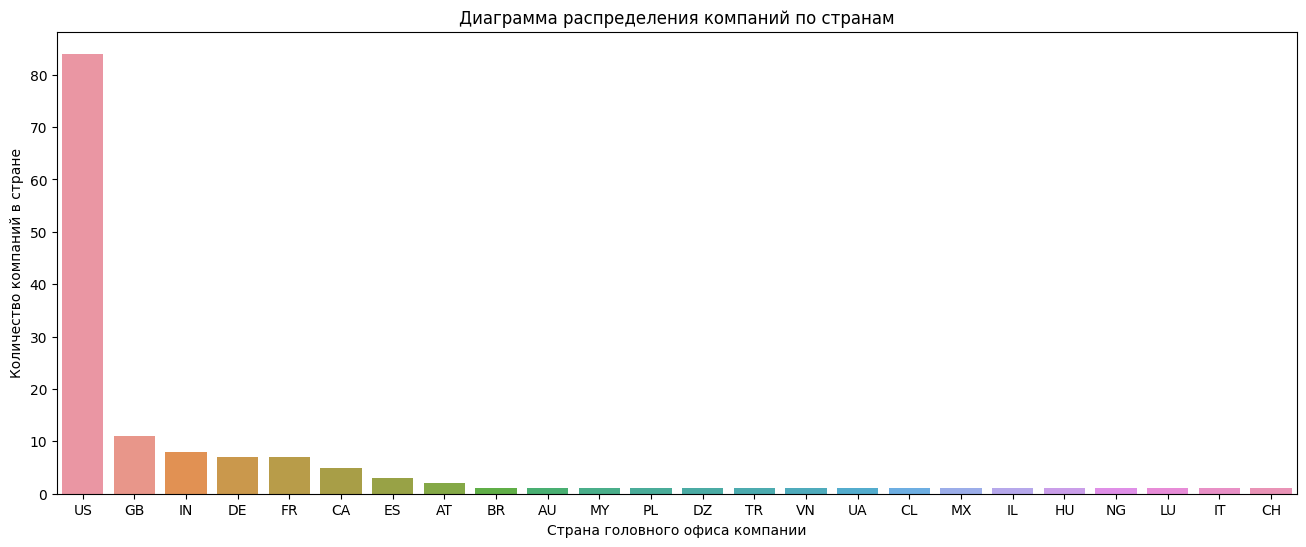

In [15]:
# построение столбчатой диаграммы количества компаний в каждой стране

fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    data=ds_data,
    x='company_location',
    order=ds_data['company_location'].value_counts().index
)
ax.set(xlabel='Страна головного офиса компании', ylabel='Количество компаний в стране')
ax.set_title('Диаграмма распределения компаний по странам');

Мы видим, что большая часть голосных офисов компаний находится в США. Так как в остальных странах количество компаний менее 10, то распределение зарплаты в этих странах будет не совсем коррректным, так как компаний слишком мало для выборок.

## 4.5 Размер компании (company_size)

Рассмотрим распределение зарплаты специалистов Data Scientist по размеру компаний.

- S — менее 50 сотрудников (небольшая компания);
- M — от 50 до 250 сотрудников (средняя компания);
- L — более 250 сотрудников (крупная компания).

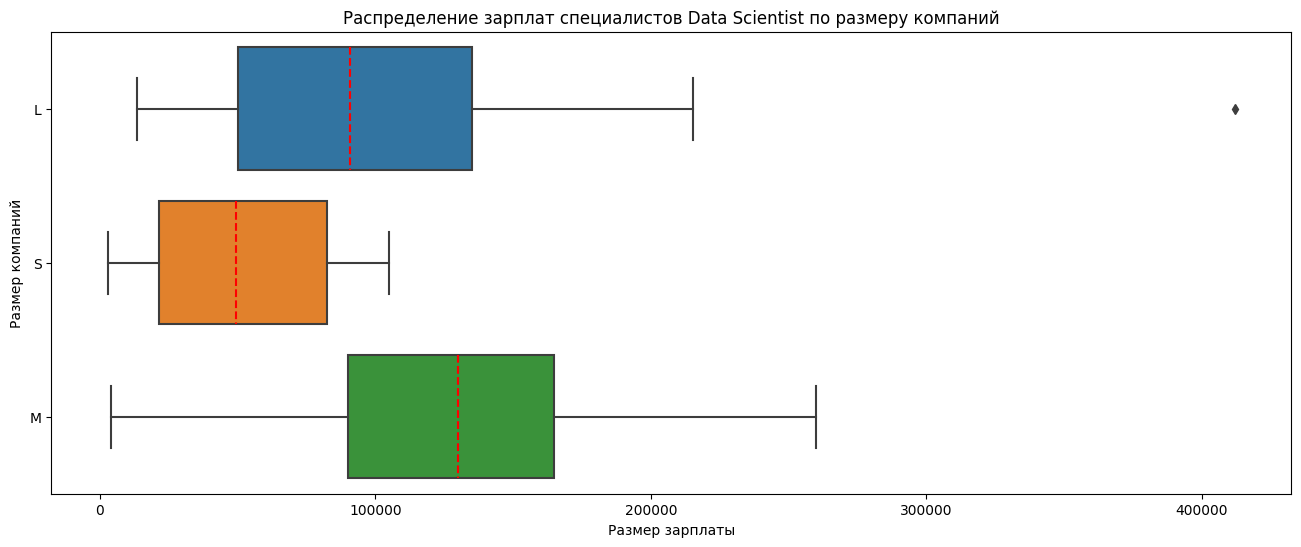

In [16]:
# построение коробчатой диаграммы распределения зарплат по размеру компании

fig, ax = plt.subplots(figsize=(16,6))

sns.boxplot(
    data=ds_data,
    x='salary_in_usd',
    y='company_size',
    orient='h',
    medianprops={
        'color': 'red',
        'linestyle': '--'
    }
);

ax.set(xlabel='Размер зарплаты', ylabel='Размер компаний')
ax.set_title('Распределение зарплат специалистов Data Scientist по размеру компаний');

Выведем основные статистические характеристики:

In [17]:
# вывод основных статистических характеристик

ds_agg = ds_data.groupby('company_size')['salary_in_usd'].describe().round(2)

display(ds_agg)

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


По полученным данным, зарплаты специалистов Data Scientist в крупных компаниях больше зарплат небольших компаниях, но меньше, чем в средних компаниях.  

# 5. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist

Рассмотрим распределения зарплат для каждого года. Построим коробчатую диаграмму и гистограмму.

In [18]:
# выделение зарплат специалистов Data Scientist в отдельный датафрейм

ds_salary = data[data['job_title'] == 'Data Scientist']
ds_salary.reset_index(drop=True, inplace=True)

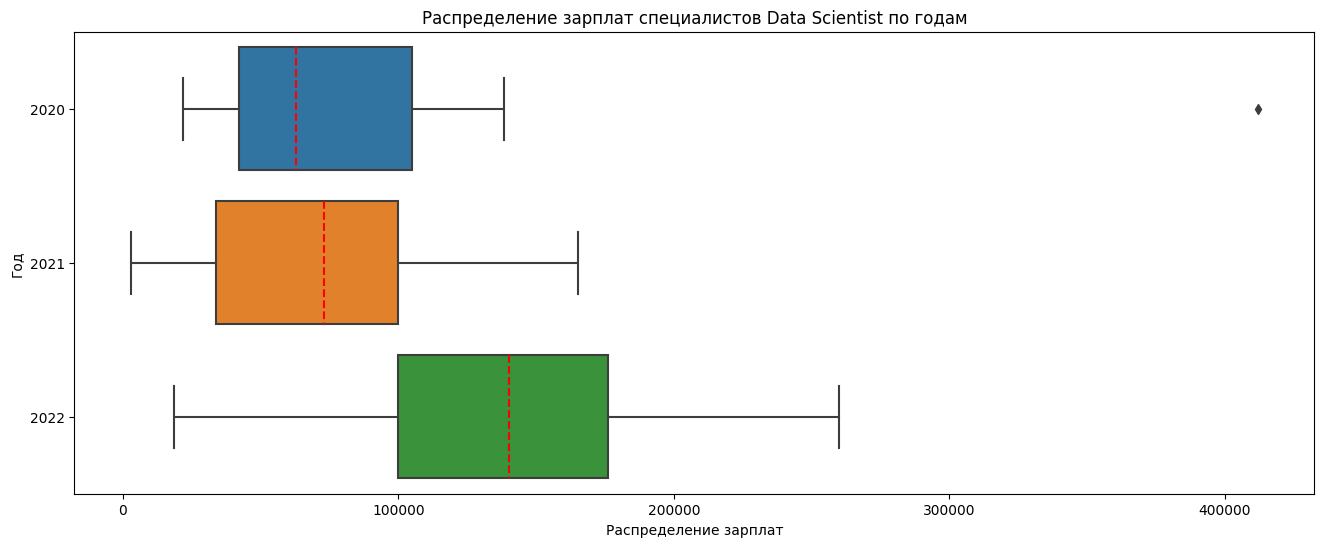

In [19]:
# построение коробчатой диаграммы распределения зарплат по годам

fig, ax = plt.subplots(figsize=(16,6))

sns.boxplot(
    data=ds_salary,
    x='salary_in_usd',
    y='work_year',
    orient='h',
    medianprops={
        'color': 'red',
        'linestyle': '--'
    }
)

ax.set(xlabel='Распределение зарплат', ylabel='Год')
ax.set_title('Распределение зарплат специалистов Data Scientist по годам');

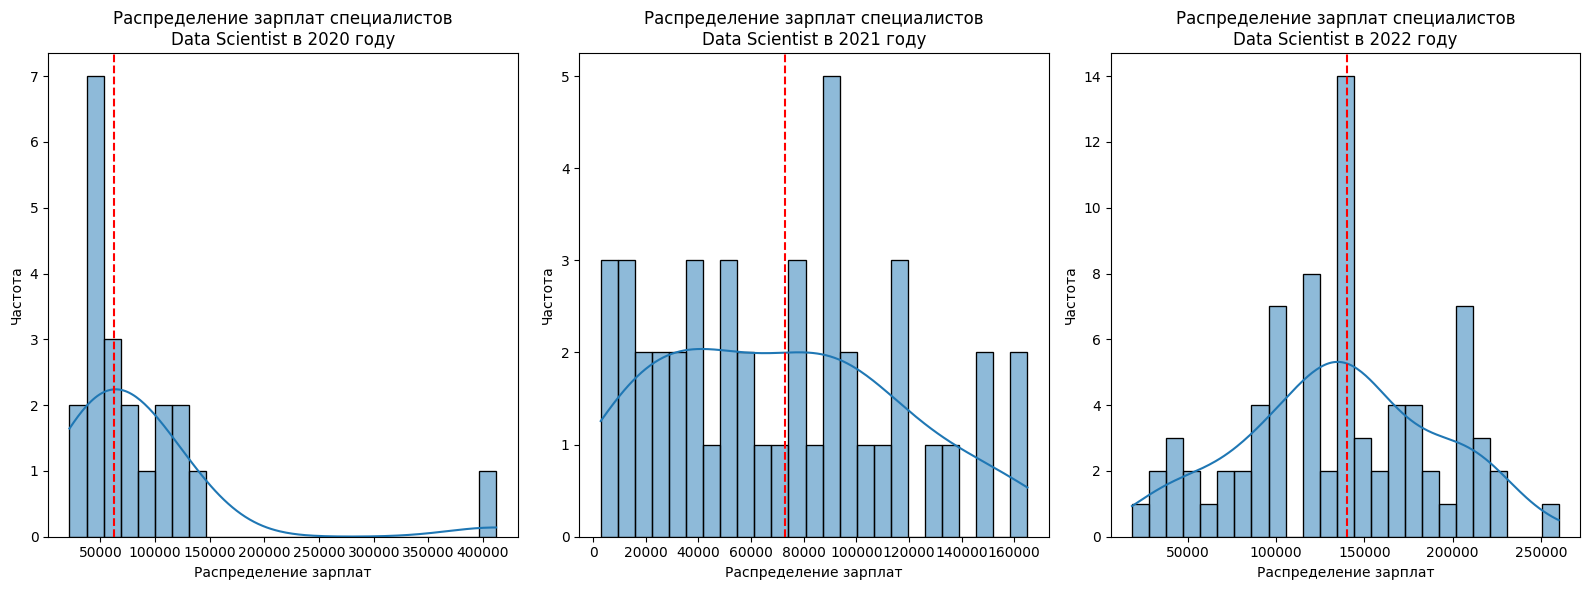

In [20]:
# построение гистрограмм распределения зарплат отдельно для каждого года

fig, axes = plt.subplots(1, 3, figsize=(16,6))

sns.histplot(
    data=ds_salary[ds_salary['work_year'] == 2020]['salary_in_usd'],
    kde=True,
    ax=axes[0],
    bins=25
)
axes[0].axvline(ds_salary[ds_salary['work_year'] == 2020]['salary_in_usd'].median(), color='red', linestyle='--')
axes[0].set(xlabel='Распределение зарплат', ylabel='Частота')
axes[0].set_title('Распределение зарплат специалистов\nData Scientist в 2020 году')

sns.histplot(
    data=ds_salary[ds_salary['work_year'] == 2021]['salary_in_usd'],
    kde=True,
    ax=axes[1],
    bins=25
)
axes[1].axvline(ds_salary[ds_salary['work_year'] == 2021]['salary_in_usd'].median(), color='red', linestyle='--')
axes[1].set(xlabel='Распределение зарплат', ylabel='Частота')
axes[1].set_title('Распределение зарплат специалистов\nData Scientist в 2021 году')

sns.histplot(
    data=ds_salary[ds_salary['work_year'] == 2022]['salary_in_usd'],
    kde=True,
    ax=axes[2],
    bins=25
)
axes[2].axvline(ds_salary[ds_salary['work_year'] == 2022]['salary_in_usd'].median(), color='red', linestyle='--')
axes[2].set(xlabel='Распределение зарплат', ylabel='Частота')
axes[2].set_title('Распределение зарплат специалистов\nData Scientist в 2022 году')

fig.tight_layout();

Выведем основные статистические характеристики:

In [21]:
# вывод основных статистических характеристик

data_agg = ds_salary.groupby('work_year')['salary_in_usd'].describe().round(2)
display(data_agg)

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Медианное значение размера зарплаты c каждым годом увеличивается, что может говорить о ежегодном росте зарплат у специалистов Data Science. Для того, чтобы в этом убедиться, проведем статистическое тестирование. Для работы нам понадобятся две функции, которые будут проверять на нормальность и принятии решения об отклонении нулевой гипотезы.

Перед началом работы зададим уровень значимости `alpha` равный 0.05

In [22]:
# зададим уровень значимости

alpha = 0.05

In [23]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print(f'p-value = {p:.3f}')

    if p <= alpha:
        print(f'р-значение меньше, чем заданный уровень значимости {alpha:.2f}. Распределение отлично от нормального.')
    else:
        print(f'р-значение больше, чем заданный уровень значимости {alpha:.2f}. Распределение является нормальным.')

# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print(f'p-value = {p:.3f}')

    if p<= alpha:
        print(f'р-значение меньше, чем заданный уровень значимости {alpha:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.')
    else:
        print(f'р-значение больше, чем заданный уровень значимости {alpha:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.')

Чтобы выяснить, наблюдается ли ежегодный рост зарплат у специалистов Data Scientist, сравним зарплаты в 2020 году с зарплатами в 2021 году и зарплаты в 2021 году с зарплатами в 2022 году.

Для этого проведем два статистических теста.

### 1. Сравним зарплаты в 2020 и в 2021 годах

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза ($H_0$)*: зарплаты у специалистов Data Scientist в 2021 году ($m_1$) меньше или равны зарплатам в 2020 году ($m_2$).
$$H_0: m_1 <= m_2$$

*Альтернативная гипотеза ($H_1$)*: зарплаты у специалистов Data Scientist в 2021 году ($m_1$) больше, чем зарплаты в 2020 году ($m_2$).
$$H_1: m_1 > m_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза ($H_0$)*: распределение данных является нормальным.

*Альтернативная гипотеза ($H_1$)*: распределение данных отлично от нормального.

In [24]:
# зарплаты специалистов Data Science в 2020 и 2021 году

salary_2020 = ds_salary.loc[ds_salary['work_year'] == 2020, 'salary_in_usd']
salary_2021 = ds_salary.loc[ds_salary['work_year'] == 2021, 'salary_in_usd']

# проведем тест Шапиро-Уилка
print('Для зарплат за 2020 год:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('\nДля зарплат за 2021 год:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

Для зарплат за 2020 год:
p-value = 0.000
р-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.

Для зарплат за 2021 год:
p-value = 0.125
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.


**Выбираем подходящий статистический тест**

Для выбора теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признака "salary_in_usd"? - **Количественный**
- Количество сравниваемых групп? - **2 группы**
- Группы зависимы? - **Нет**
- Признак распределен по нормальному закону? - **Нет**

Для проверки нашей гипотезы можем использовать *U-критерий Манна-Уитни* для сравнения распределений на основе медианных значений.

**Проведем тест**

In [25]:
_, p = stats.mannwhitneyu(salary_2021, salary_2020, alternative='greater')
decision_hypothesis(p)

p-value = 0.685
р-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


У нас нет оснований утверждать, что зарплаты специалистов Data Scientist в 2021 году больше, чем в 2020 году. Разница в зарплатах не является статистически значимой.

### 2. Сравним зарплаты специалистов Data Scientist в 2021 и 2022 годах.

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза ($H_0$)*: зарплаты специалистов Data Scientist в 2022 году ($m_1$) меньше или равны зарплатам в 2021 году ($m_2$).
$$H_0: m_1 <= m_2$$

*Альтернативная гипотеза ($H_1$)*: зарплаты специалистов Data Scientist в 2022 году ($m_1$) больше, чем зарплаты в 2021 году ($m_2$).
$$H_1: m_1 > m_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально.

In [26]:
# зарплаты специалистов Data Science в 2021 и 2022 году

salary_2022 = ds_salary.loc[ds_salary['work_year'] == 2022, 'salary_in_usd']

# проведем тест Шапиро-Уилка

print('\nДля зарплат за 2021 год:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('\nДля зарплат за 2022 год:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])


Для зарплат за 2021 год:
p-value = 0.125
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.

Для зарплат за 2022 год:
p-value = 0.327
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.


**Выбираем подходящий статистический тест**

Для выбора теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признака "salary_in_usd"? - **Количественный**
- Количество сравниваемых групп? - **2 группы**
- Группы зависимы? - **Нет**
- Признак распределен по нормальному закону? - **Да**

Для проверки нашей гипотезы можем использовать *Двухвыбороный T-критерий* для сравнения средних значений. Перед проведением статистического теста необходимо выяснить, равны ли дисперсии. В этом нам поможет тест *Левена*.

**Проведем тест Левена на равенство дисперсий**

In [27]:
print('Проведем тест на равенство дисперсий')
result = stats.levene(salary_2021, salary_2022)
p = result[1]
print(f'p-value = {p:.3f}')

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр `equal_var=False`')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр `equal_var=True`')

Проведем тест на равенство дисперсий
p-value = 0.445
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр `equal_var=True`


In [28]:
# проведение теста на сравнение средних в группах

print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_2022, salary_2021, alternative='greater', equal_var=True)
decision_hypothesis(p)


Тест на равенство средних
p-value = 0.000
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Зарплаты специалистов Data Scientist в 2022 году больше, чем зарплаты в 2021 году.

### Вывод

Исходя из полученных в ходе тестов данных, нельзя с уверенностью сказать, что зарплаты специалистов Data Scientist ежегодно растут. Зарплаты за 2020 и 2021 года примерно одинаковы, так как не имеют статистически значимых отличий. Зарплата за 2022 год больше, чем за 2021 год. Одновременно с этим, медианное значение заработной платы с каждым годом увеличивается.

# 6. Соотношение зарплат специалистов Data Scientist и Data Engineer в 2022 году

Выделим в датасет информацию о зарплатах для Data Scientist и Data Engineer в 2022 году:

In [29]:
# выделение зарплат специлалистов Data Scientist и Data Engineer в 2020 году

mask1 = data['job_title'] == 'Data Scientist'
mask2 = data['job_title'] == 'Data Engineer'
mask3 = data['work_year'] == 2022

ds_de_salary_2022 = data[(mask1 | mask2) & mask3][['job_title', 'salary_in_usd']]
ds_de_salary_2022.reset_index(drop=True, inplace=True)
display(ds_de_salary_2022)

,job_title,salary_in_usd
0,Data Engineer,135000
1,Data Scientist,130000
2,Data Scientist,90000
3,Data Engineer,170000
4,Data Engineer,150000
...,...,...
161,Data Scientist,210000
162,Data Scientist,160000
163,Data Scientist,130000
164,Data Engineer,154000


Построим диаграммы распределений зарплат специалистов Data Scientist и Data Engineer в 2022 году:

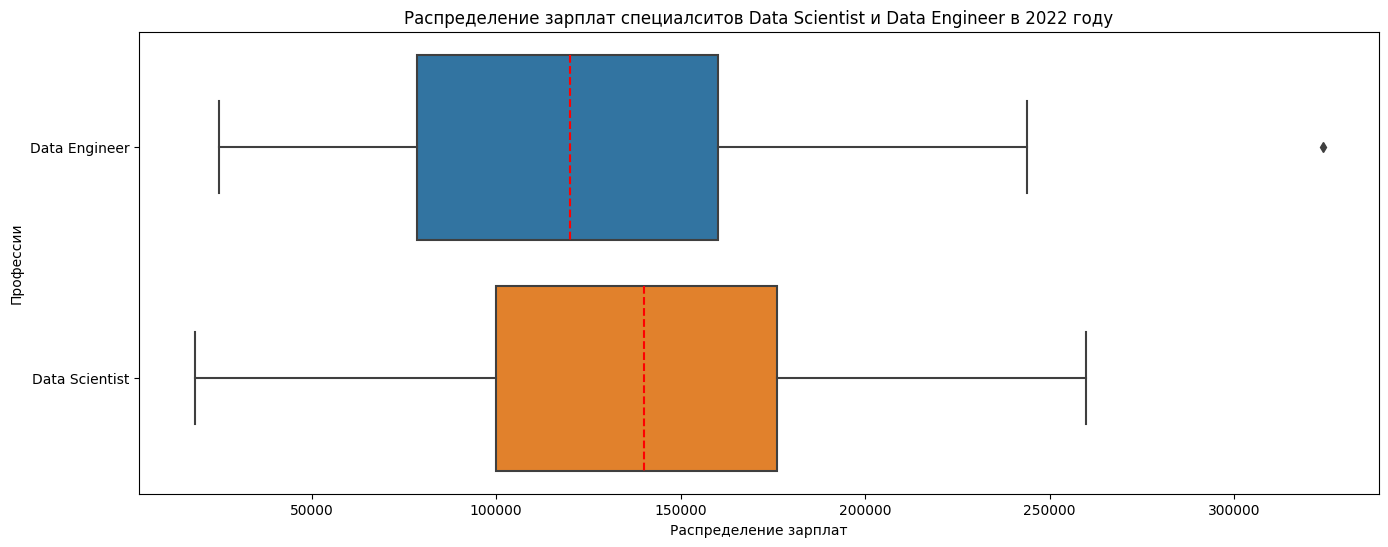

In [30]:
# построение диаграммы распределения зарплат специалистов Data Scientist и Data Engineer в 2022 году

fig, ax = plt.subplots(figsize=(16,6))

sns.boxplot(
    data=ds_de_salary_2022,
    x='salary_in_usd',
    y='job_title',
    orient='h',
    medianprops={
        'color': 'red',
        'linestyle': '--'
    }
)
ax.set(xlabel='Распределение зарплат', ylabel='Профессии')
ax.set_title('Распределение зарплат специалситов Data Scientist и Data Engineer в 2022 году');

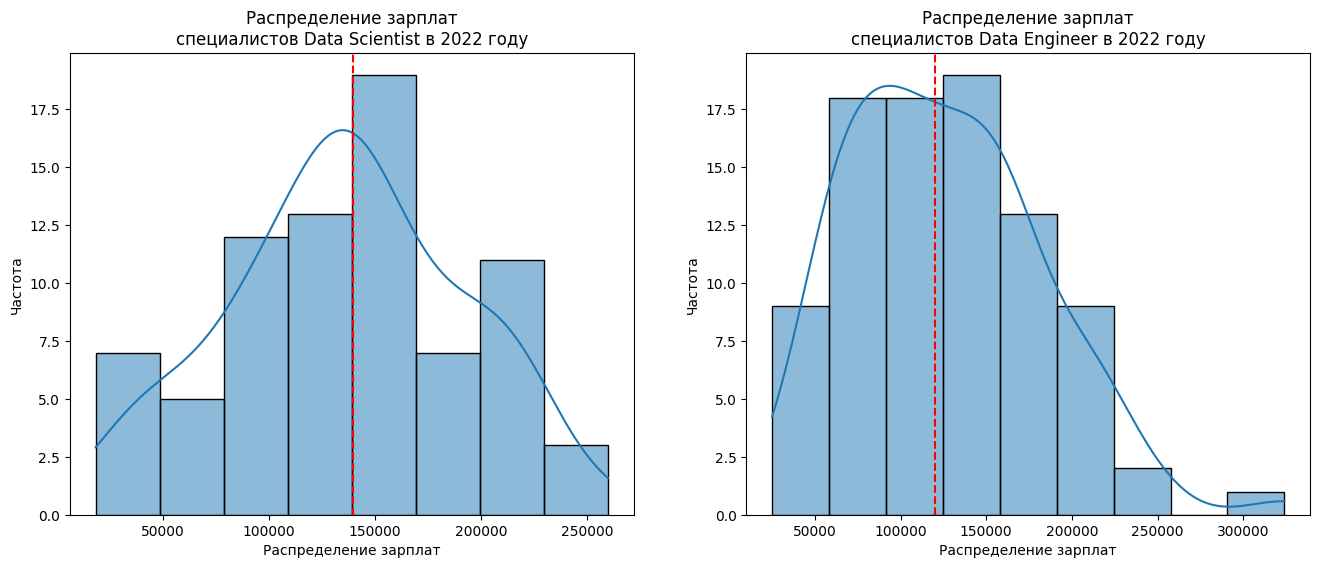

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(
    data=ds_de_salary_2022[ds_de_salary_2022['job_title'] == 'Data Scientist']['salary_in_usd'],
    kde=True,
    ax=ax[0]
)
ax[0].set(xlabel='Распределение зарплат', ylabel='Частота')
ax[0].set_title('Распределение зарплат\nспециалистов Data Scientist в 2022 году')
ax[0].axvline(ds_de_salary_2022[ds_de_salary_2022['job_title'] == 'Data Scientist']['salary_in_usd'].median(), color='red', linestyle='--')

sns.histplot(
    data=ds_de_salary_2022[ds_de_salary_2022['job_title'] == 'Data Engineer']['salary_in_usd'],
    kde=True,
    ax=ax[1]
)
ax[1].set(xlabel='Распределение зарплат', ylabel='Частота')
ax[1].set_title('Распределение зарплат\nспециалистов Data Engineer в 2022 году')
ax[1].axvline(ds_de_salary_2022[ds_de_salary_2022['job_title'] == 'Data Engineer']['salary_in_usd'].median(), color='red', linestyle='--');

Выведем основные статистические характеристики:

In [32]:
# вывод основных статистических характеристик

data_agg = ds_de_salary_2022.groupby('job_title')['salary_in_usd'].describe().round(2)
display(data_agg)

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,89.0,126375.70,55954.40,25000.0,78526.0,120000.0,160000.0,324000.0
Data Scientist,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


По полученным данным зарплаты специалистов Data Scientist и Data Engineer за 2022 год различны: медианное значение зарплат специалистов Data Scientist больше меддианного значения зарплат специалистов Data Engineer. Определим, имеет ли это различие статистическую значимость. Для этого проведем статистический тест. 


**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза ($H_0$)*: зарплата специалистов Data Scientist ($\mu_1$) меньше либо равна зарплате специалистов Data Engineer ($\mu_2$).
$$H_0: \mu_1 <= \mu_2$$

*Альтернативная гипотеза ($H_1$)*: зарплата специалистов Data Scientist ($\mu_1$) больше зарплаты специалистов Data Engineer ($\mu_2$).
$$H_1: \mu_1 > \mu_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределен ли признак нормально:

In [33]:
# проверка поризнаков на нормальность

ds_salary_2022 = ds_de_salary_2022.loc[ds_de_salary_2022['job_title'] == 'Data Scientist', 'salary_in_usd']
de_salary_2022 = ds_de_salary_2022.loc[ds_de_salary_2022['job_title'] == 'Data Engineer', 'salary_in_usd']

# проведем тест Шапиро-Уилка
print('Для специалисто Data Scientist')
result = stats.shapiro(ds_salary_2022)
decision_normality(result[1])

print('Для специалистов Data Engineer')
result = stats.shapiro(de_salary_2022)
decision_normality(result[1])

Для специалисто Data Scientist
p-value = 0.327
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Для специалистов Data Engineer
p-value = 0.010
р-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора тесте. Для этого ответим на следующие вопросы:
- Какой тип данных у признака "salary_in_usd"? - **Количественный**
- Количество сравниваемых групп? - **2 группы**
- Группы зависимы? - **Нет**
- Признак распределен по нормальному закому? - **Нет**

Для проверки нашей гипотезы можем использовать *U-критерий Манна-Уитни*.

In [34]:
# проведение статистического теста

_, p = stats.mannwhitneyu(ds_salary_2022, de_salary_2022, alternative='greater')
decision_hypothesis(p)

p-value = 0.077
р-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

У нас нет оснований утверждать, что зарплаты специалистов Data Scientist больше зарплат специалистов Data Engineer. На вопрос "Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?" ответом будет утверждение, что зарплаты специалистов примерно равны, различия не являются статистически значимыми.

Дополнительно можно повторно провести тест, проверив двустороннюю гипотезу: в качестве нулевой гипотезы - размеры зарплат равны, а в качестве альтернативной - размеры зарплат не равны:
- `alternative='two-sided'`.

Получаем `p-value = 0.155`. Нет оснований отвергнуть нулевую гипотезу, из чего делаем вывод, что статистически размеры заплат специалистов Data Scientist и Data Engineer равны.

# 7. Соотношение зарплат специалистов Data Scientist в компаниях различных размеров

Выделим в датасет данные о зарплатах специалистов Data Scientist в различных по размеру компаниях:

In [35]:
# выделение зарплат специалистов Data Scientist в различных компаниях

ds_companies_salary = data[data['job_title'] == 'Data Scientist'][['company_size', 'salary_in_usd']]
ds_companies_salary.reset_index(drop=True, inplace=True)
display(ds_companies_salary)

,company_size,salary_in_usd
0,L,79833
1,L,35735
2,S,51321
3,L,40481
4,M,39916
...,...,...
138,M,230000
139,M,150000
140,M,210000
141,M,160000


Построим диаграммы распределений зарплат специалистов Data Scientist в различных по размеру компаниях:

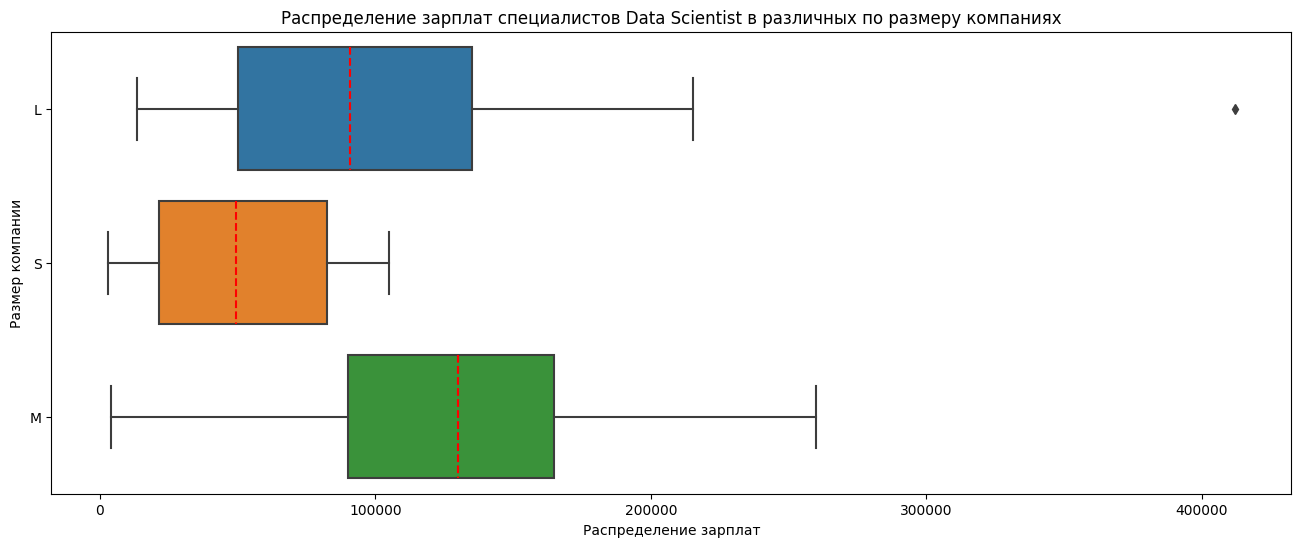

In [36]:
# построение коробчатой диаграммы распределения

fig, ax = plt.subplots(figsize=(16,6))

sns.boxplot(
    data=ds_companies_salary,
    x='salary_in_usd',
    y='company_size',
    orient='h',
    medianprops={
        'color': 'red',
        'linestyle': '--'
    }
)

ax.set(xlabel='Распределение зарплат', ylabel='Размер компании')
ax.set_title('Распределение зарплат специалистов Data Scientist в различных по размеру компаниях');

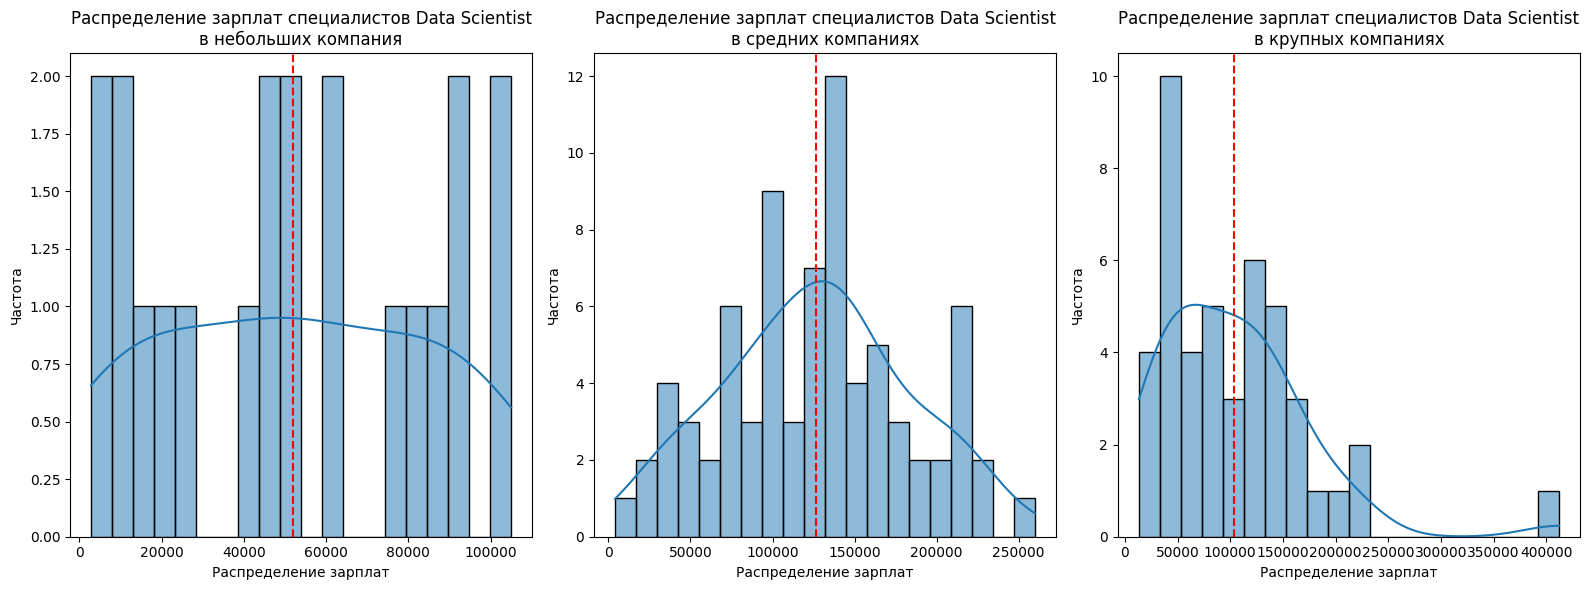

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(
    data=ds_companies_salary[ds_companies_salary['company_size'] == 'S']['salary_in_usd'],
    kde=True,
    ax=ax[0],
    bins=20
)
ax[0].set(xlabel='Распределение зарплат', ylabel='Частота')
ax[0].set_title('Распределение зарплат специалистов Data Scientist\nв небольших компания')
ax[0].axvline(ds_companies_salary[ds_companies_salary['company_size'] == 'S']['salary_in_usd'].mean(), color='red', linestyle='--')

sns.histplot(
    data=ds_companies_salary[ds_companies_salary['company_size'] == 'M']['salary_in_usd'],
    kde=True,
    ax=ax[1],
    bins=20
)
ax[1].set(xlabel='Распределение зарплат', ylabel='Частота')
ax[1].set_title('Распределение зарплат специалистов Data Scientist\nв средних компаниях')
ax[1].axvline(ds_companies_salary[ds_companies_salary['company_size'] == 'M']['salary_in_usd'].mean(), color='red', linestyle='--')

sns.histplot(
    data=ds_companies_salary[ds_companies_salary['company_size'] == 'L']['salary_in_usd'],
    kde=True,
    ax=ax[2],
    bins=20
)
ax[2].set(xlabel='Распределение зарплат', ylabel='Частота')
ax[2].set_title('Распределение зарплат специалистов Data Scientist\nв крупных компаниях')
ax[2].axvline(ds_companies_salary[ds_companies_salary['company_size'] == 'L']['salary_in_usd'].mean(), color='red', linestyle='--')

fig.tight_layout();

Выведем основные статистические характеристики:

In [38]:
# вывод основных статистических характеристик

data_agg = ds_companies_salary.groupby('company_size')['salary_in_usd'].describe().round(2)
display(data_agg)

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


По полученным данным можно сделать вывод, что зарплаты специалистов Data Scientist в различных по размеру компаниях отличаются.

Сравним зарплаты специалистов Data Scientist в различных по размеру компаниях попарно, чтобы выяснить, влияет ли размер компании на размер зарплаты.

Предположим, что размер зарплаты прямо пропорционален размеру компании. Для начала сравним зарплаты специалистов Data Scientist в небольших и средних компаниях.

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза ($H_0$)*: размер зарплаты специалистов Data Scientist в средних компаниях ($\mu_1$) меньше или равен размеру зарплат в небольших компаниях ($\mu_2$).
$$H_0: \mu_1 <= \mu_2$$

*Альтернативная гипотеза ($H_1$)*: размер зарплаты специалистов Data Scientist в средних компаниях ($\mu_1$) больше, чем в небольших компаниях ($\mu_2$).
$$H_1: \mu_1 > \mu_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределен ли признак нормально:

In [39]:
# проверка признаков на нормальность

s_size_company_salary = ds_companies_salary.loc[ds_companies_salary['company_size'] == 'S', 'salary_in_usd']
m_size_company_salary = ds_companies_salary.loc[ds_companies_salary['company_size'] == 'M', 'salary_in_usd']

print('Для небольших компаний:')
result = stats.shapiro(s_size_company_salary)
decision_normality(result[1])

print('\nДля средних компаний:')
result = stats.shapiro(m_size_company_salary)
decision_normality(result[1])

Для небольших компаний:
p-value = 0.189
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.

Для средних компаний:
p-value = 0.639
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признака "salary_in_usd"? - **Количественный**
- Количество сравниваемых групп? - **2 группы**
- Группы зависимы? - **Нет**
- Признак распределен по нормальному закону? - **Да**

Для проверки гипотезы можем использовать *Двухвыборочный T-критерий*.

**Проведем тест Левена на равенство дисперсий**

In [40]:
# проводим тест Левина
print('Проводим тест на равенство дисперсий')

result = stats.levene(s_size_company_salary, m_size_company_salary)
p = result[1]
print(f'p-value = {p:.3f}')

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр `equal_var=False`.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр `equal_var=True`.')

Проводим тест на равенство дисперсий
p-value = 0.025
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр `equal_var=False`.


In [41]:
# проводим тест на сраавнение средних в группах

print('Тест на равенство средних')
_, p = stats.ttest_ind(m_size_company_salary, s_size_company_salary, alternative='greater', equal_var=False)
decision_hypothesis(p)

Тест на равенство средних
p-value = 0.000
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Зарплаты специалистов Data Scientist в средних компаниях больше, чем зарплаты в небольших компаниях.

Теперь сравним зарплаты специалистов Data Scientist в средних и крупных компаниях.

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза ($H_0$)*: зарплаты специалистов Data Scientist в крупных компаниях ($\mu_1$) меньше или равно зарплатам в средних компаниях ($\mu_2$).
$$H_0: \mu_1 <= \mu_2$$

*Альтернативная гипотеза ($H_1$)*: зарплаты специалистов Data Scientist в крупных компаниях ($\mu_1$) больше, чем зарплаты в средних компаниях ($\mu_2$).
$$H_1: \mu_1 > \mu_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределен ли признак нормально

In [42]:
# распределение зарплат в крупных компаниях

l_size_company_salary = ds_companies_salary.loc[ds_companies_salary['company_size'] == 'L', 'salary_in_usd']

print('Для средних компаний:')
result = stats.shapiro(m_size_company_salary)
decision_normality(result[1])

print('\nДля крупных компаний:')
result = stats.shapiro(l_size_company_salary)
decision_normality(result[1])

Для средних компаний:
p-value = 0.639
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.

Для крупных компаний:
p-value = 0.000
р-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признака "salary_in_usd"? - **Количественный**
- Количество сравниваемых групп? - **2 группы**
- Группы зависимы? - **Нет**
- Признак распределен по нормальному закону? - **Нет**

Для проверки гипотезы можем использовать *U-критерий Манна-Уитни*.

In [43]:
# проведем статистический тест

_, p = stats.mannwhitneyu(l_size_company_salary, m_size_company_salary, alternative='greater')
decision_hypothesis(p)

p-value = 0.994
р-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Нет оснований утверждать, что зарплаты специалистов Data Scientist в крупных компаниях больше, чем в средних компаниях.

**Вывод**

По полученным данным, предположение о том, что размер зарплаты специалистов Data Scientist прямо пропорционально размеру компании, оказалось неверным. По результатам теста самый низкий размер заработной платы оказался в небольших компаниях; размер зарплаты в крупных и средних компаниях не имеют статистически значимой разницы.

# 8. Проверка связи между наличием должностей Data Scientist и Data Engineer и размером компании

Создадим категориальные бинарные признаки, показывающие, соответствует ли должность Data Scientist и Data Engineer.

In [44]:
# создание бинарных признаков - наличие в компании специалистов Data Scientist и Data Engineer

data['is_ds'] = data['job_title'].apply(lambda x: 'yes' if x == 'Data Scientist' else 'no')
data['is_de'] = data['job_title'].apply(lambda x: 'yes' if x == 'Data Engineer' else 'no')

Выведем соотношение наличия и отсутствия в компании различных размеров специалистов Data Scientist и Data Engineer.

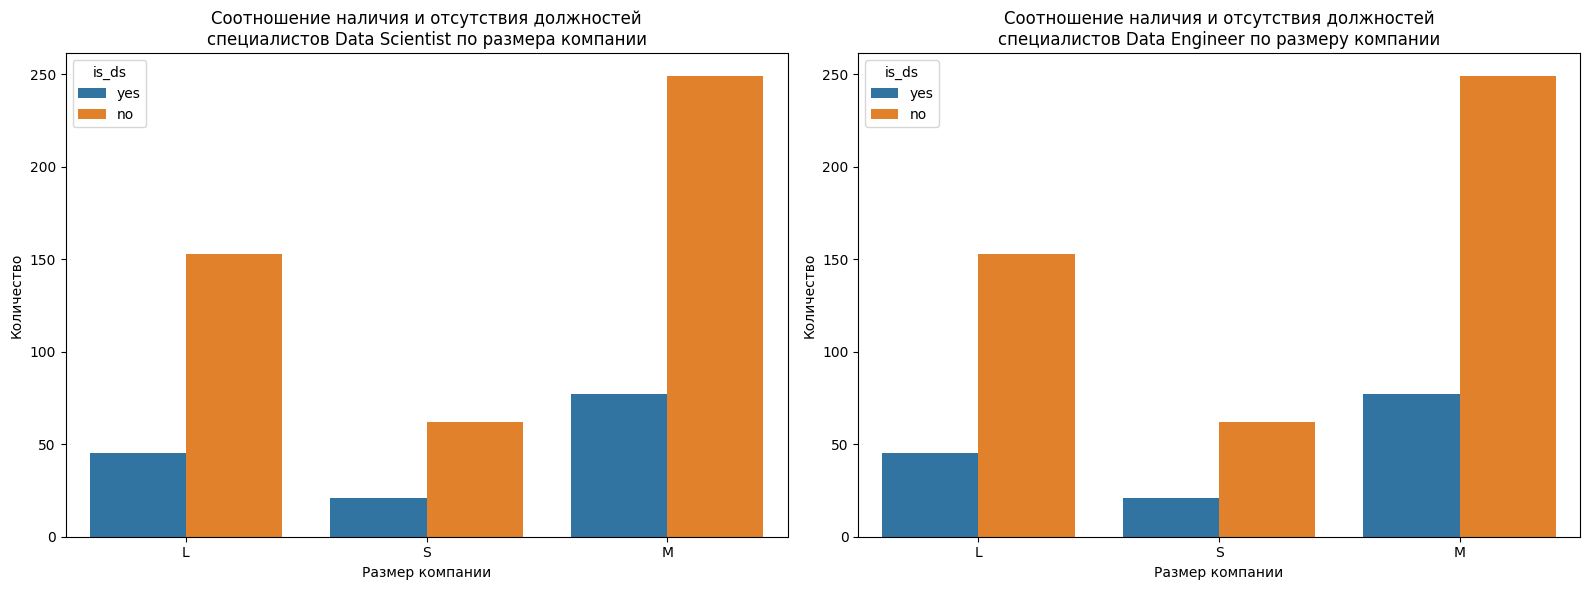

In [45]:
# построение соотношения наличия специалистов в компаниях различных размеров

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(
    data=data,
    x=data['company_size'],
    hue='is_ds',
    ax=ax[0]
)
ax[0].set(xlabel='Размер компании', ylabel='Количество')
ax[0].set_title('Соотношение наличия и отсутствия должностей\nспециалистов Data Scientist по размера компании')

sns.countplot(
    data=data,
    x=data['company_size'],
    hue='is_ds',
    ax=ax[1]
)
ax[1].set(xlabel='Размер компании', ylabel='Количество')
ax[1].set_title('Соотношение наличия и отсутствия должностей\nспециалистов Data Engineer по размеру компании')

fig.tight_layout()

Построим таблицы сопряженности для Data Scientist и Data Engineer, а зетем - тепловые карты по ним:

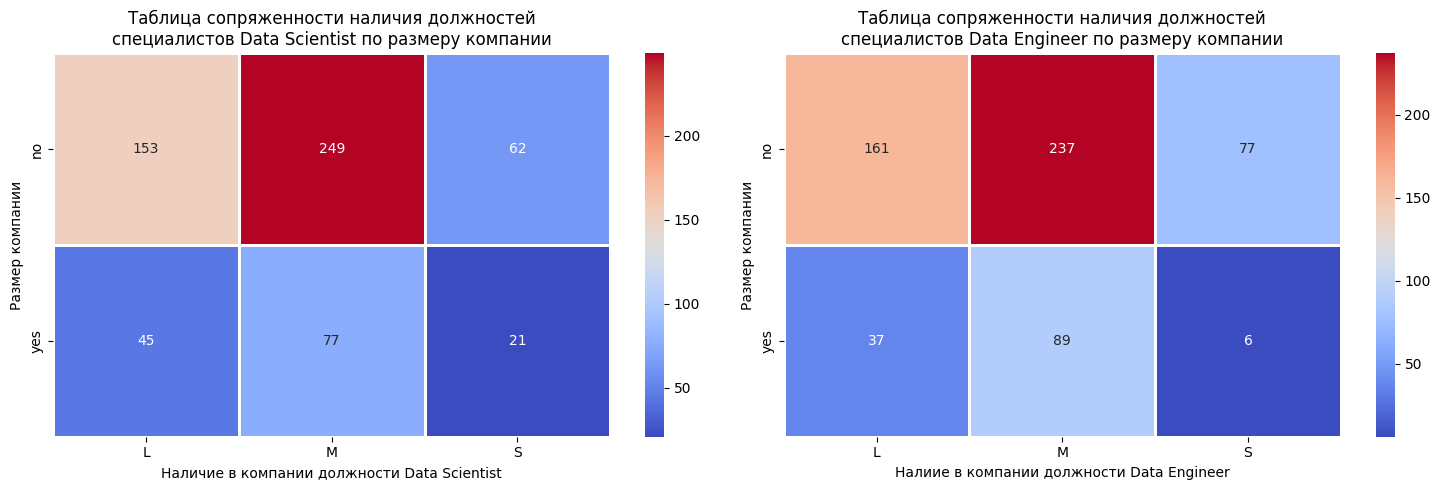

In [46]:
# построение таблиц сопряженности и тепловых карт

cross_tab_ds = pd.crosstab(
    index=data['is_ds'],
    columns=data['company_size']
)
cross_tab_de = pd.crosstab(
    index=data['is_de'],
    columns=data['company_size']
)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(
    cross_tab_ds,
    annot=True,
    linewidth=1,
    fmt='.0f',
    cmap='coolwarm',
    ax=ax[0]
)
ax[0].set(xlabel='Наличие в компании должности Data Scientist', ylabel='Размер компании')
ax[0].set_title('Таблица сопряженности наличия должностей\nспециалистов Data Scientist по размеру компании')

sns.heatmap(
    cross_tab_de,
    annot=True,
    linewidth=1,
    fmt='.0f',
    cmap='coolwarm',
    ax=ax[1]
)
ax[1].set(xlabel='Налиие в компании должности Data Engineer', ylabel='Размер компании')
ax[1].set_title('Таблица сопряженности наличия должностей\nспециалистов Data Engineer по размеру компании')

fig.tight_layout();

Согласно полученным данным, отношение должностей специалистов Data Scientist и Data Engineer к общему числу должностей в компаниях разных размеров примерно одинаково. Таким образом, связь между наличием должностей Data Scientist и Data Engineer и размером компании отсутствует. Для того, чтобы определить, являются ли эта гипотеза верной, проведем статистические тесты: проверим сперва для должности Data Scientist, а затем - для должности Data Engineer.

**Сформулируем нулевую и альтернативные гипотезы**

*Для специалистов Data Scientist*

*Нулевая гипотеза*: между наличием должности Data Scientist и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должности Data Scientist и размером компании есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного статистического теста воспользуемся алгоритмом выбора теста. Для этого ответим на следуующие вопросы:
- Какой тип у признаков "company_size" и "is_ds"? - **Категориальный**
- Количество сравниваемых групп? - **2 группы**
- Проверяется независимость групп? - **Да**

Для проверки нашей гипотезы можем использовать *критерий $\chi^2$* (хи-квадрат).

**Проведем тест**

In [47]:
# составление таблицы сопряженности
cross_table_ds = pd.crosstab(
    index=data['company_size'],
    columns=data['is_ds']
)

display(cross_table_ds)

is_ds,no,yes
company_size,,
L,153,45
M,249,77
S,62,21


In [48]:
# проведение статистического теста
_, p, _, _ = stats.chi2_contingency(cross_table_ds)
decision_hypothesis(p)

p-value = 0.897
р-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


*Для специалистов Data Engineer*

*Нулевая гипотеза*: между наличием должности Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должности Data Engineer и размером компании есть взаимосвязь (признаки зависимы).

**Выберем подходящий тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признаков "company_size" и "is_de"? - **Категориальный**
- Количество сравниваемых групп? - **2 группы**
- Проверяется независимость групп? - **Да**

Для проверки нашей гипотезы можем использовать *критерий $\chi^2$* (хи-квадрат).

**Проведем тест**

In [49]:
# составление таблицы сопряженности
cross_table_de = pd.crosstab(
    index=data['company_size'],
    columns=data['is_de']
)
display(cross_table_de)

is_de,no,yes
company_size,,
L,161,37
M,237,89
S,77,6


In [50]:
# проведение статистического теста
_, p, _, _ = stats.chi2_contingency(cross_table_de)
decision_hypothesis(p)

p-value = 0.000
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Между наличием должности *Data Scientist* и размером компании нет взаимосвязи. Но между наличием должности *Data Engineer* и размером компании взаимосвязь присутствует.

Проверим теперь если ли связь между одновременным наличием должностей *Data Scientist* и *Data Engineer* и размером компании. Для этого добавим бинарный признак, показывающий наличие в компании должностей Data Scientist и Data Engineer.

In [51]:
# добавление бинарного признака

data['ds_de'] = data['job_title'].apply(lambda x: 'yes' if x == 'Data Scientist' or x == 'Data Engineer' else 'no')

Составим таблицы сопряженности и построим диаграммы соотношения наличия должностей в компаниях различных размеров:

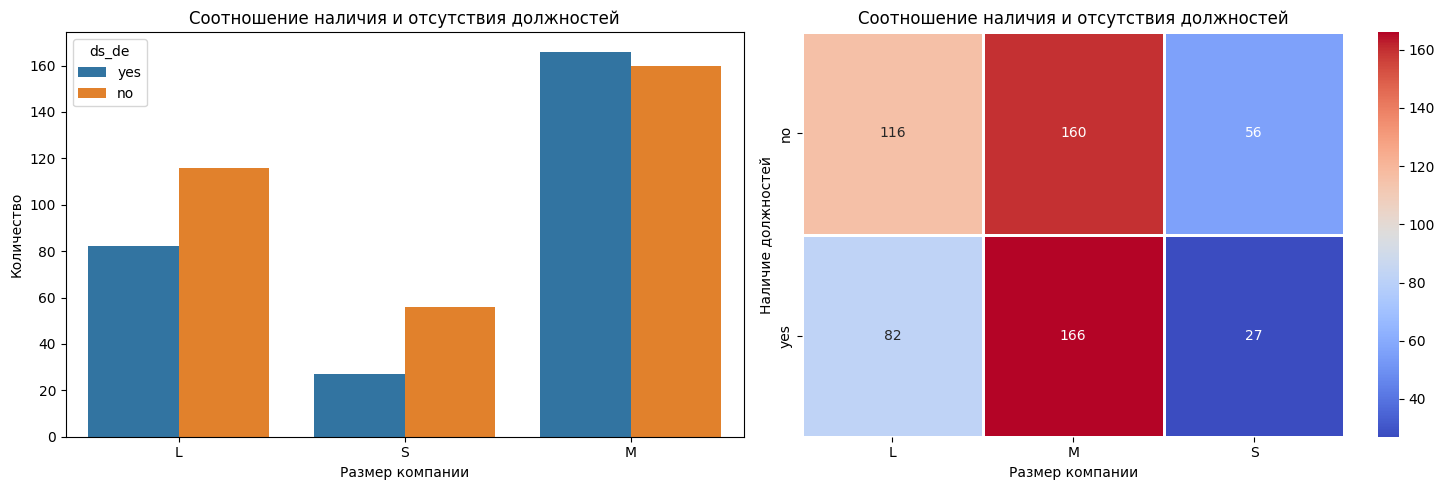

In [52]:
# составление таблицы сопряженности и построение диаграмм

cross_table = pd.crosstab(
    index=data['ds_de'],
    columns=data['company_size']
)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(
    data=data,
    x=data['company_size'],
    hue='ds_de',
    ax=ax[0]
)
ax[0].set(xlabel='Размер компании', ylabel='Количество')
ax[0].set_title('Соотношение наличия и отсутствия должностей')

sns.heatmap(
    cross_table,
    annot=True,
    linewidth=1,
    fmt='.0f',
    cmap='coolwarm',
    ax=ax[1]
)
ax[1].set(xlabel='Размер компании', ylabel='Наличие должностей')
ax[1].set_title('Соотношение наличия и отсутствия должностей')

fig.tight_layout();

Согласно данным, соотношение должностей *Data Scientist* и *Data Engineer* к общему количеству сотрудников больше в средних и крупных компаниях, меньше - в небольших. Чтобы определить, есть ли взаимосвязь между наличием этих должностей и размером компании, проведем статистический тест.

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: между наличием должностей *Data Scientist* и *Data Engineer* и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей *Data Scientist* и *Data Engineer* и размером компании есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следуующие вопросы:
- Какой тип у признаков "company_size" и "ds_de"? - **Категориальный**
- Количество сравниваемых групп? - **2 группы**
- Проверяется неззависимость групп? - **Да**

Для проверки нашей гипотезы можем использовать *критерий $\chi^2$* (хи-квадрат).

**Проведем тест**

In [53]:
# составление таблицы сопряженности
cross_table = pd.crosstab(
    index=data['ds_de'],
    columns=data['company_size']
)

display(cross_table)

company_size,L,M,S
ds_de,,,
no,116,160,56
yes,82,166,27


In [54]:
# проведение теста

_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.004
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует значимая статистическая связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании.

# 9. Дополнительные исследования

## 9.1 Проверка взаимосвязи между опытом работы специалистов Data Scientist и размером компании

Предположим, что есть взаимосвязь между опытом работы специалиста и размером компании, в которой он работает. Выясним, так ли это. Для начала составим таблицу сопряженности и выведем диаграммы:

In [55]:
# составление таблицы сопряженности между опытом работы и размером компании

df = data.copy()
df = df[df['job_title'] == 'Data Scientist']

dct = {
    'EN': 1,
    'MI': 2,
    'SE': 3,
    'EX': 4
}

df['experience_level'] = df['experience_level'].apply(lambda x: dct[x])

cross_table = pd.crosstab(
    index=df['experience_level'],
    columns=df['company_size']
)

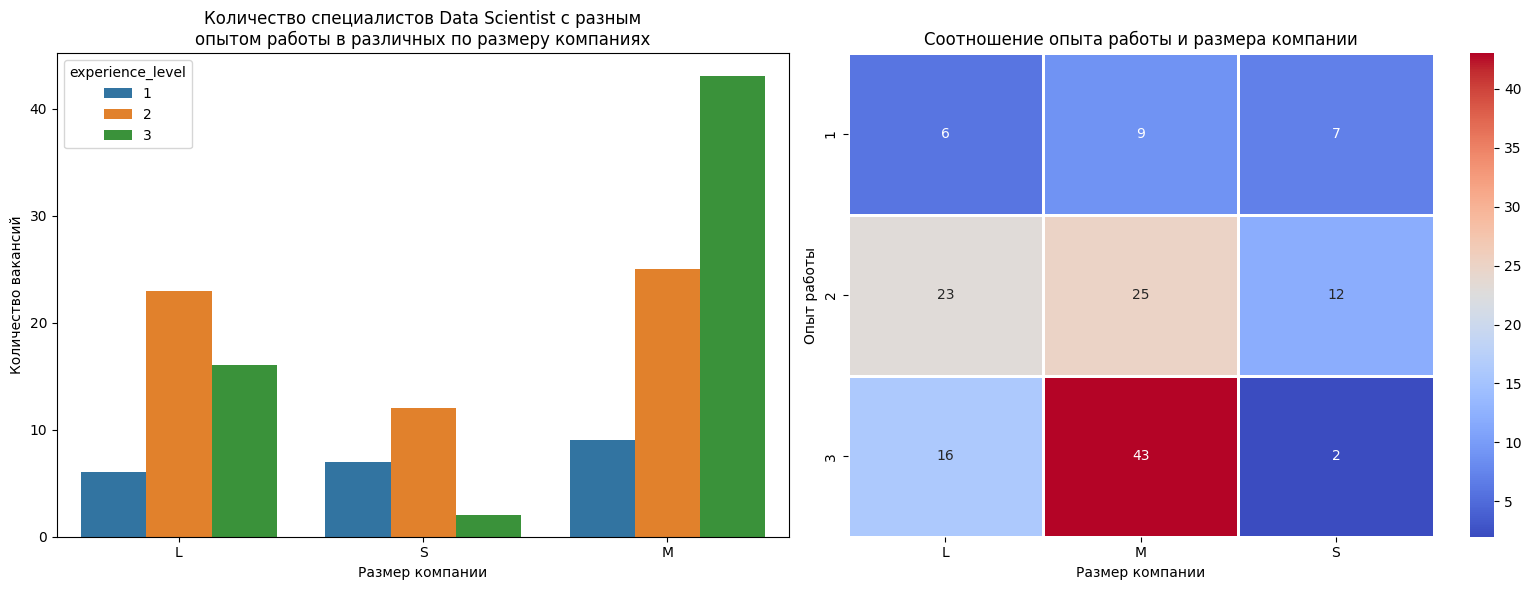

In [56]:
# построение диаграмм

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(
    data=df,
    x=df['company_size'],
    hue=df['experience_level'],
    ax=ax[0]
)
ax[0].set(xlabel='Размер компании', ylabel='Количество вакансий')
ax[0].set_title('Количество специалистов Data Scientist с разным\nопытом работы в различных по размеру компаниях')

sns.heatmap(
    cross_table,
    annot=True,
    linewidths=1,
    fmt='.0f',
    cmap='coolwarm',
    ax=ax[1]
)
ax[1].set(xlabel='Размер компании', ylabel='Опыт работы')
ax[1].set_title('Соотношение опыта работы и размера компании')

fig.tight_layout();

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гитопеза:* между опытом работы и размером компании нет взаимосвязи.

*Альтернативная гитопеза:* между опытом работы и размером копании есть взаимосвязь.

**Выберем подходящий статистический тест**

Для выбора статистического теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признаков "experience_level" и "company_size"? - **Категориальный**
- Количество сравниваемых групп? - **2 группы**
- Проверяется независимость групп? - **Да**

Для проверки нашей гипотезы можем использовать критерий $\chi^2$ (хи-квадрат).

**Проведем тест**

In [57]:
# проведение статистического теста

_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.001
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Данные теста показывают, что между опытом работы и размером компании есть взаимосвязь.

## 9.2 Проверка взаимосвязи между опытом работы и объемом работы, выполняемой удаленно

Предположим, что есть взаимосвязь между объемом выполняемой удаленной работы и опытом работы специалиста. Выясним, так ли это. Составим таблицу сопряженности и выведем диаграмму:

In [58]:
# составление таблицы сопряженности между опытом работы и количеством выполняемой удаленной работы

cross_table = pd.crosstab(
    index=df['remote_ratio'],
    columns=df['experience_level']
)

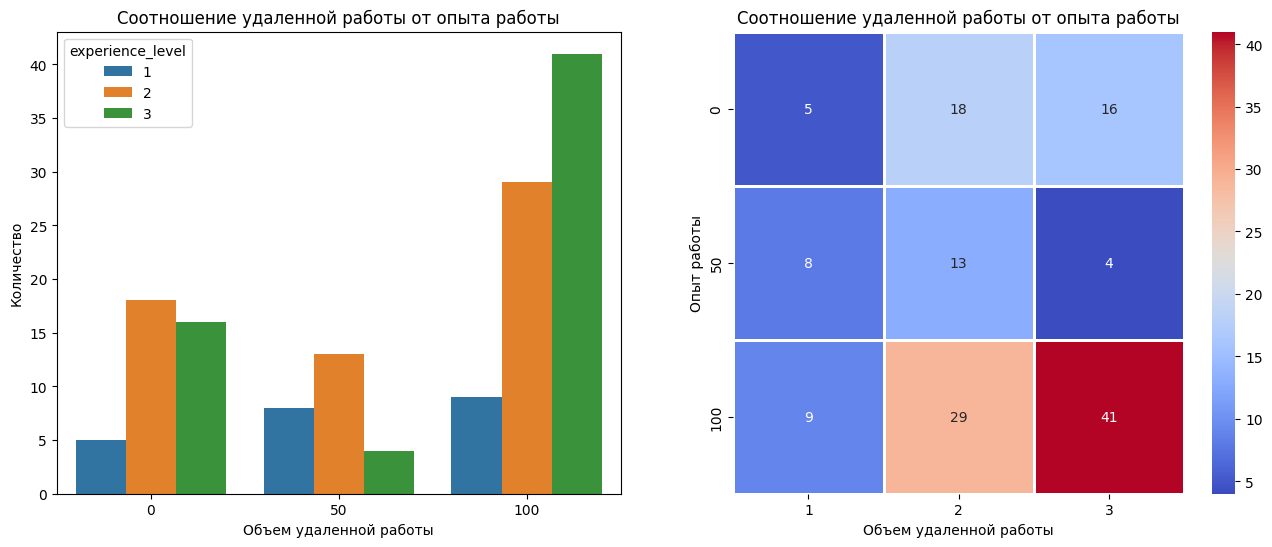

In [59]:
# построение диаграмм

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(
    data=df,
    x=df['remote_ratio'],
    hue=df['experience_level'],
    ax=ax[0]
)
ax[0].set(xlabel='Объем удаленной работы', ylabel='Количество')
ax[0].set_title('Соотношение удаленной работы от опыта работы')

sns.heatmap(
    cross_table,
    annot=True,
    linewidth=1,
    fmt='.0f',
    cmap='coolwarm',
    ax=ax[1]
)
ax[1].set(xlabel='Объем удаленной работы', ylabel='Опыт работы')
ax[1].set_title('Соотношение удаленной работы от опыта работы');

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гитопеза:* между опытом работы и объемом удаленной работы нет взаимосвязи.

*Альтернативная гитопеза:* между опытом работы и объемом удаленной работы есть взаимосвязь.

**Выберем подходящий статистический тест**

Для выбора статистического теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признаков "experience_level" и "company_size"? - **Категориальный**
- Количество сравниваемых групп? - **2 группы**
- Проверяется независимость групп? - **Да**

Для проверки нашей гипотезы можем использовать критерий $\chi^2$ (хи-квадрат).

**Проведем тест**

In [60]:
# провдение статистического теста

_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.014
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Данные теста показывают, что между опытом работы и объемом удаленной работы есть взаимосвязь.

## 9.3 Проверка взаимосвязи между размером зарплат от опыта работы для специалистов Data Scientist

Рассмотрим влияние опыта работы на размер зарплаты специалистов Data Scientist. Предположим, что с увеличением опыта работы растет и зараплата. Узнаем, сколько типов опыта работы представлено для специалистов Data Scientist.

In [61]:
display(df['experience_level'].value_counts())

3    61
2    60
1    22
Name: experience_level, dtype: int64

Специалисты Data Scientist в нашем датафрейме имеют 3 типа опыта работы:
 - 1 - Junior;
 - 2 - Intermediate;
 - 3 - Expert.

 Расмотрим распределение зарплат для каждого из типов опыта работы. Для этого построим диаграмммы и выведем основные статичтические харакетеристики.

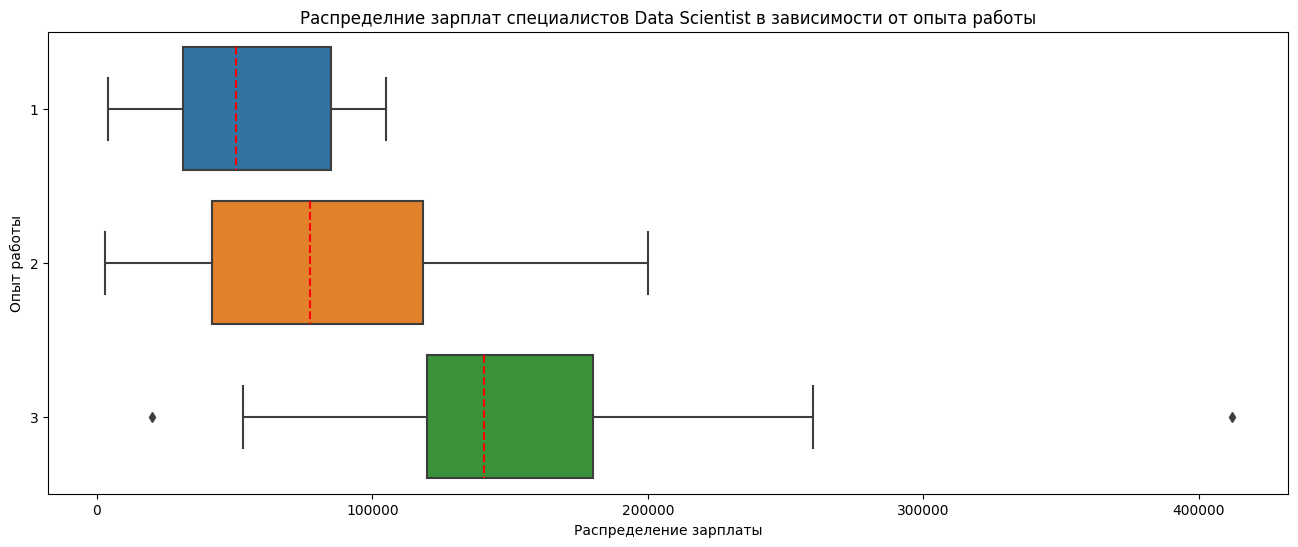

In [62]:
# построение коробчатой диаграммы

fig, ax = plt.subplots(figsize=(16,6))

sns.boxplot(
    data=df,
    x='salary_in_usd',
    y='experience_level',
    orient='h',
    medianprops={
        'color': 'red',
        'linestyle': '--'
    }
)
ax.set(xlabel='Распределение зарплаты', ylabel='Опыт работы')
ax.set_title('Распределние зарплат специалистов Data Scientist в зависимости от опыта работы');

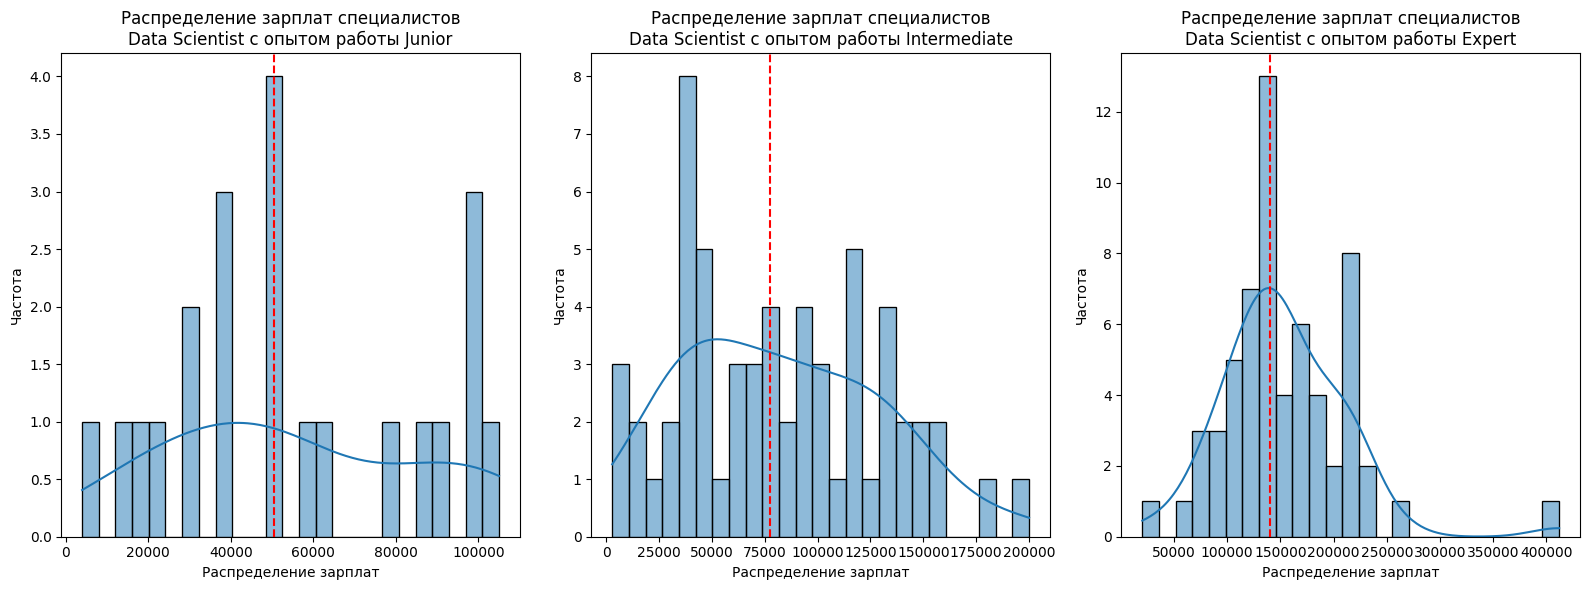

In [63]:
# построение гистограмм для каждого типа опыта работы

fig, ax = plt.subplots(1, 3, figsize=(16,6))

sns.histplot(
    data=df[df['experience_level'] == 1]['salary_in_usd'],
    kde=True,
    ax=ax[0],
    bins=25
)
ax[0].axvline(df[df['experience_level'] == 1]['salary_in_usd'].median(), color='red', linestyle='--')
ax[0].set(xlabel='Распределение зарплат', ylabel='Частота')
ax[0].set_title('Распределение зарплат специалистов\nData Scientist с опытом работы Junior')

sns.histplot(
    data=df[df['experience_level'] == 2]['salary_in_usd'],
    kde=True,
    ax=ax[1],
    bins=25
)
ax[1].axvline(df[df['experience_level'] == 2]['salary_in_usd'].median(), color='red', linestyle='--')
ax[1].set(xlabel='Распределение зарплат', ylabel='Частота')
ax[1].set_title('Распределение зарплат специалистов\nData Scientist с опытом работы Intermediate')

sns.histplot(
    data=df[df['experience_level'] == 3]['salary_in_usd'],
    kde=True,
    ax=ax[2],
    bins=25
)
ax[2].axvline(df[df['experience_level'] == 3]['salary_in_usd'].median(), color='red', linestyle='--')
ax[2].set(xlabel='Распределение зарплат', ylabel='Частота')
ax[2].set_title('Распределение зарплат специалистов\nData Scientist с опытом работы Expert');

fig.tight_layout()

In [64]:
# вывод основных статистических характеристик

data_agg = df.groupby('experience_level')['salary_in_usd'].describe().round(2)

display(data_agg)

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
1,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
2,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
3,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


По диаграммам и медианам можно увидеть, что с увеличением опыта работы растет и зарплата. Проведем статистические тесты чтобы выяснить, есть ли между зарплатами статистически значимые отличия.

Проведем два теста: сравним зарплаты специалистов Data Scientist с опытом работы Junior и Intermediate, а затем - Intermediate и Expert.

**1. Сравнение зарплат специалистов Data Scientist с опытом работы Junior и Intermediate.**

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза ($H_0$)*: зарплаты у специалистов Data Scientist с опытом работы *Intermediate* ($m_1$) меньше или равны зарплатам с опытом *Junior* ($m_2$).
$$H_0: m_1 <= m_2$$

*Альтернативная гипотеза ($H_1$)*: зарплаты у специалистов Data Scientist с опытом работы *Intermediate* ($m_1$) больше, чем зарплаты с опытом *Junior* ($m_2$).
$$H_0: m_1 > m_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза ($H_0$)*: распределение данных является нормальным.

*Альтернативная гипотеза ($H_1$)*: распределение данных отлично от нормального.

In [65]:
# проведем тест Шапиро-Уилка

salary_jun = df.loc[df['experience_level'] == 1, 'salary_in_usd']
salary_inter = df.loc[df['experience_level'] == 2, 'salary_in_usd']

print('Для зарплат с опытом работы Junior:')
result = stats.shapiro(salary_jun)
decision_normality(result[1])

print('\nДля зарплат с опытом работы Intermediate:')
result = stats.shapiro(salary_inter)
decision_normality(result[1])

Для зарплат с опытом работы Junior:
p-value = 0.174
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.

Для зарплат с опытом работы Intermediate:
p-value = 0.178
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.


**Выбираем подходящий статистический тест**

Для выбора теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признака "salary_in_usd"? - **Количественный**
- Количество сравниваемых групп? - **2 группы**
- Группы зависимы? - **Нет**
- Признак распределен по нормальному закону? - **Да**

Для проверки нашей гипотезы можем использовать *Двухвыборочный t-критерий* для сравнения средних значений.

**Проведем тест**

Перед проведением теста сделаем проверку на равенство дисперсий в группах. Для этого воспользуемся функцией `levene()`.

In [66]:
# проверка на равенство дисперсий

result = stats.levene(salary_jun, salary_inter)
p = result[1]

print(f'p-value = {p:.3f}')

if p <= alpha:
    print('Дисперсии неодинаковы, в stats.ttest_ind нужно использовать equal_var=False')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать equal_var=True')

p-value = 0.029
Дисперсии неодинаковы, в stats.ttest_ind нужно использовать equal_var=False


In [67]:
# двухвыборочный t-критерий

_, p = stats.ttest_ind(salary_inter, salary_jun, alternative='greater', equal_var=False)
decision_hypothesis(p)

p-value = 0.002
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Данные теста говорят о том, что зарплата у специалистов Data Scientist с опытом работы *Intermediate* выше, чем с опытом работы *Junior*.

**2. Сравнение зарплат специалистов Data Scientist с опытом работы Intermediate и Expert.**

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза ($H_0$)*: зарплаты у специалистов Data Scientist с опытом работы *Expert* ($m_1$) меньше или равны зарплатам с опытом *Intermediate* ($m_2$).
$$H_0: m_1 <= m_2$$

*Альтернативная гипотеза ($H_1$)*: зарплаты у специалистов Data Scientist с опытом работы *Expert* ($m_1$) больше, чем зарплаты с опытом *Intermediate* ($m_2$).
$$H_0: m_1 > m_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза ($H_0$)*: распределение данных является нормальным.

*Альтернативная гипотеза ($H_1$)*: распределение данных отлично от нормального.

In [68]:
# проведем тест Шапиро-Уилка

salary_exp = df.loc[df['experience_level'] == 3, 'salary_in_usd']

print('Для зарплат с опытом работы Intermediate:')
result = stats.shapiro(salary_inter)
decision_normality(result[1])

print('\nДля зарплат с опытом работы Expert:')
result = stats.shapiro(salary_exp)
decision_normality(result[1])

Для зарплат с опытом работы Intermediate:
p-value = 0.178
р-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.

Для зарплат с опытом работы Expert:
p-value = 0.000
р-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


**Выбираем подходящий статистический тест**

Для выбора теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
- Какой тип у признака "salary_in_usd"? - **Количественный**
- Количество сравниваемых групп? - **2 группы**
- Группы зависимы? - **Нет**
- Признак распределен по нормальному закону? - **Нет**

Для проверки нашей гипотезы можем использовать *U-критерий Манна-Уитни* для сравнения распределений на основе медианных значений.

**Проведем тест**

In [69]:
_, p = stats.mannwhitneyu(salary_exp, salary_inter, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
р-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Данные теста говорят о том, что зарплаты у специалистов Data Scientist с опытом работы *Expert* выше, чем с опытом работы *Intermediate*.

**Вывод**

Проведенные статистические тесты подтвердили гипотезу о том, что у специалистов Data Scientist с увеличением опыта работы растет и заработная плата.

# Вывод по проделанной работе

В ходе исследования выяснили, что наибольшее влияние на размер зарплат специалистов Data Scientist оказывают:
- Опыт работы специалиста: чем больше опыт работы, тем выше размер зарплаты;
- Объем работы, выполняемой удаленно: специалисты, частично выполняющие работу удаленно, зарабатывают меньше, чем специалисты, которые выполняют всю работу удаленно или не выполняют ее вовсе;
- Размер компании: в средних по размеру компаниях зарплата у специалистов Data Scientist выше, чем в крупных и небольших компаниях.